In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras import backend as K

In [ ]:
# Load MNIST and normalize to [0,1]
(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Add channel dimension
x_train = np.expand_dims(x_train, -1)  # shape (N,28,28,1)
x_test = np.expand_dims(x_test, -1)

print('x_train shape:', x_train.shape, 'x_test shape:', x_test.shape)


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
x_train shape: (60000, 28, 28, 1) x_test shape: (10000, 28, 28, 1)


In [ ]:
# Create noisy versions of the images
noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy  = x_test  + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy  = np.clip(x_test_noisy, 0., 1.)

print('Noisy shapes:', x_train_noisy.shape, x_test_noisy.shape)


Noisy shapes: (60000, 28, 28, 1) (10000, 28, 28, 1)


In [ ]:
input_img = Input(shape=(28,28,1))

# Encoder
x = Conv2D(32, (3,3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2,2), padding='same')(x)
x = Conv2D(16, (3,3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2,2), padding='same', name='bottleneck')(x)

# Decoder
x = Conv2D(16, (3,3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2,2))(x)
x = Conv2D(32, (3,3), activation='relu', padding='same')(x)
x = UpSampling2D((2,2))(x)
decoded = Conv2D(1, (3,3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bottleneck (MaxPooling2D)       │ (None, 7, 7, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 7, 7, 16)       │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 14, 14, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 14, 14, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 28, 28, 1)      │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,193 (47.63 KB)

 Trainable params: 12,193 (47.63 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
epochs = 20
batch_size = 128

history = autoencoder.fit(
    x_train_noisy, x_train,
    epochs=epochs,
    batch_size=batch_size,
    shuffle=True,
    validation_data=(x_test_noisy, x_test)
)


Epoch 1/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - loss: 0.2954 - val_loss: 0.1278
Epoch 2/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.1259 - val_loss: 0.1165
Epoch 3/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.1162 - val_loss: 0.1113
Epoch 4/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.1115 - val_loss: 0.1083
Epoch 5/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.1089 - val_loss: 0.1073
Epoch 6/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.1069 - val_loss: 0.1045
Epoch 7/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.1057 - val_loss: 0.1037
Epoch 8/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.1045 - val_loss: 0.1027
Epoch 9/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.1035 - val_loss: 0.1022
Epoch 10/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.1030 - val_loss: 0.1015
Epoch 11/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.1025 - val_loss: 0.1010
Epoch 12/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/st

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


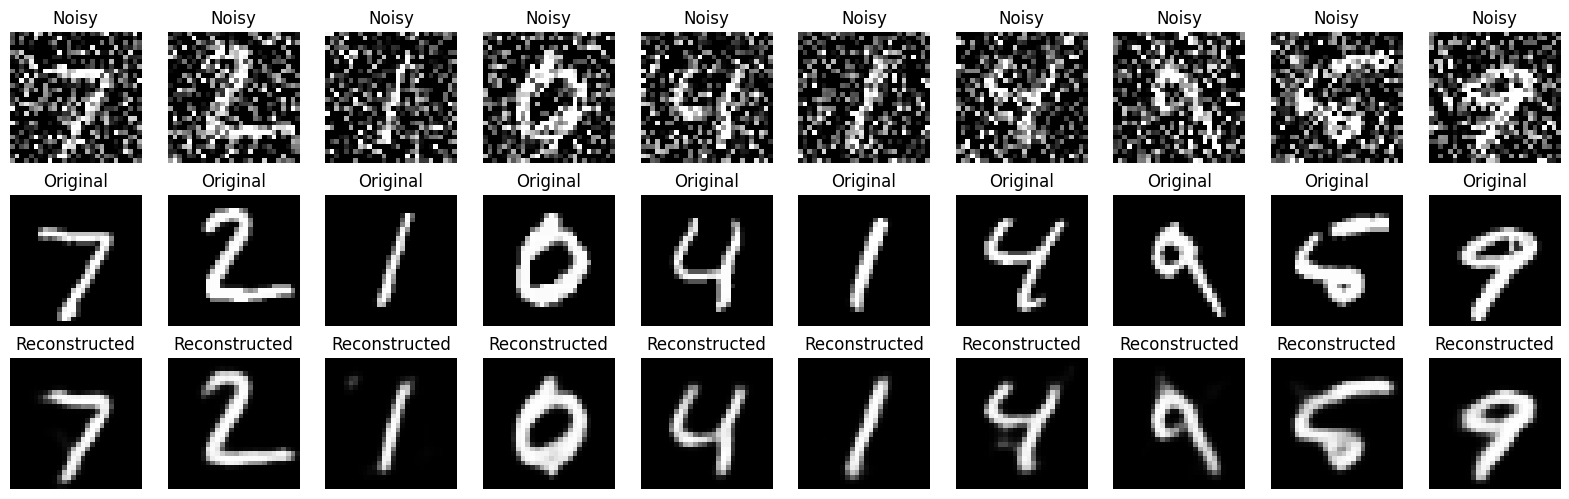

In [ ]:
decoded_imgs = autoencoder.predict(x_test_noisy)

n = 10
plt.figure(figsize=(20, 6))
for i in range(n):
    # display noisy
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test_noisy[i].reshape(28, 28), cmap='gray')
    plt.title('Noisy')
    plt.axis('off')

    # display original
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(x_test[i].reshape(28, 28), cmap='gray')
    plt.title('Original')
    plt.axis('off')

    # display reconstruction
    ax = plt.subplot(3, n, i + 1 + 2*n)
    plt.imshow(decoded_imgs[i].reshape(28, 28), cmap='gray')
    plt.title('Reconstructed')
    plt.axis('off')

plt.show()
